In [1]:
import os
import numba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import entropy
from toolz import frequencies, sliding_window, compose, partial
from aging.dlight.windowing import window_trials_as_mtx
from aging.dlight.stats import bootstrap_lineplot, bootstrap_ci
from aging.behavior.syllables import relabel_by_usage
from aging.plotting import legend, format_plots, figure, save_factory, PlotConfig

In [2]:
numba.set_num_threads(int(os.environ.get("SLURM_JOB_CPUS_PER_NODE", 1)))

In [3]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "dlight", tight_layout=False)

In [4]:
version = 12
file = Path(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/dlight_photometry_df_filter_stats_da_paper.parquet"
)

In [5]:
def zscore(arr):
    return (arr - arr.mean()) / arr.std()

In [6]:
df = pd.read_parquet(file)
df['syllables'] = df['syllables'].ffill().astype(int)

In [7]:
from toolz import partial
from aging.dlight.normalize import rolling_fluor_normalization

In [8]:
norm_func = partial(rolling_fluor_normalization, window_size=10, quantile=0.5)
df['dlight_reref_zscore'] = norm_func(df['dlight_dff'] - df['uv_reference_fit'])

In [9]:
df = relabel_by_usage(df, return_map=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8249401 entries, 0 to 8249400
Data columns (total 23 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   pmt00_ref00 (dLight)        float64       
 1   pmt00_ref01 (UV)            float64       
 2   timestamp                   float64       
 3   raw_timestamp               float64       
 4   fs                          float64       
 5   ir_indices                  float64       
 6   subject_name                object        
 7   session_name                object        
 8   start_time                  datetime64[us]
 9   syllables                   int64         
 10  velocity                    float64       
 11  uuid                        object        
 12  dlight_dff                  float64       
 13  uv_dff                      float64       
 14  dlight_reref                float64       
 15  uv_reference_fit            float64       
 16  dlight_reref_zscor

In [11]:
df['subject_name'].unique()

array(['98w-4', '98w-3', '98w-1', '52w-2', '52w-1', '52w-3', '52w-4',
       '12w-2', '12w-4', '12w-3', '98w-5', '12w-5', '52w-5', '98w-2',
       '12w-6', '12w-7'], dtype=object)

In [12]:
df['age'] = df['subject_name'].transform(lambda x: x.split('-')[0])

In [13]:
filt_df = df.query('snr > 4 & session_motion_corr < 0.20')

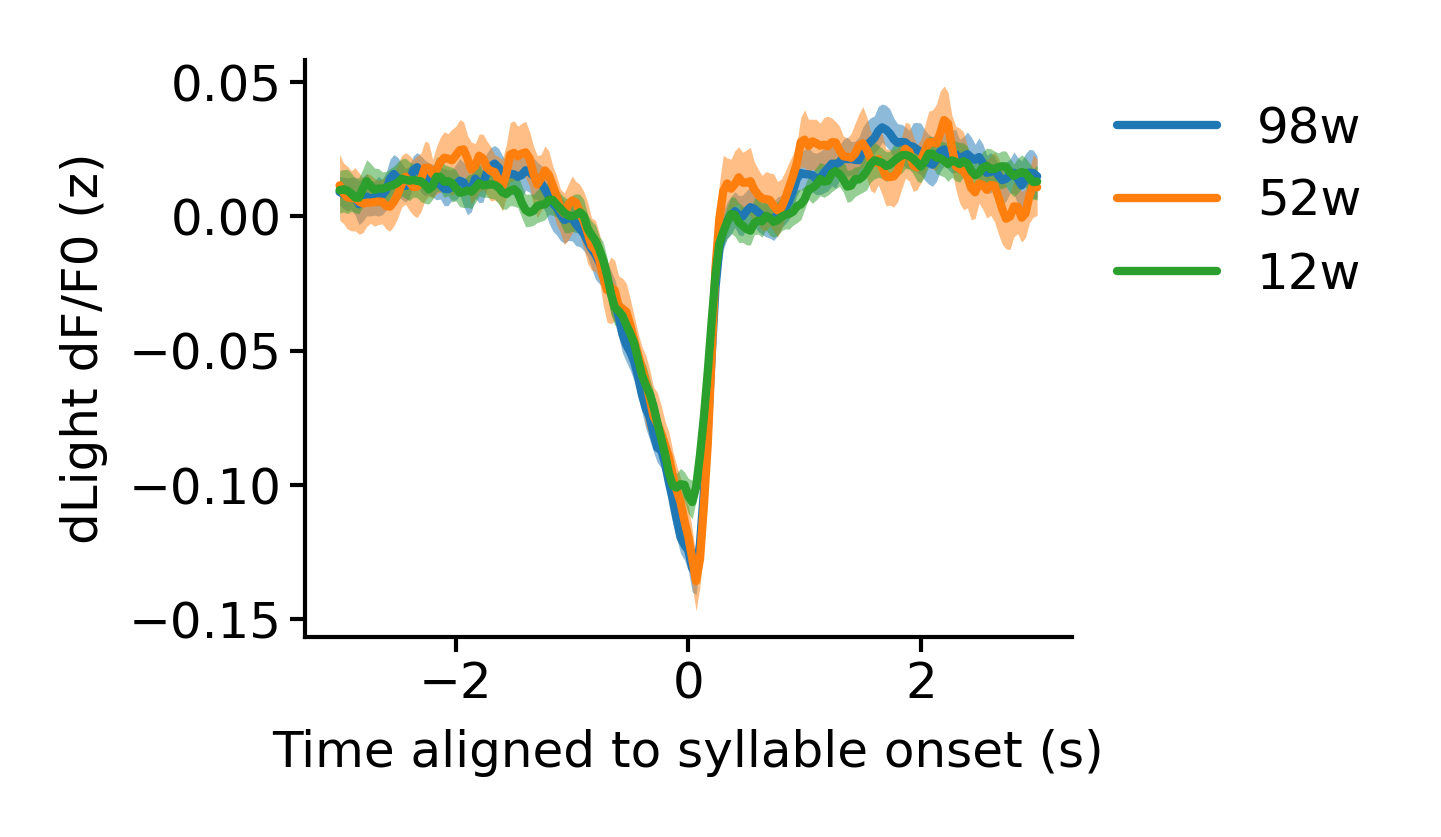

In [14]:
fig = figure(1.65, 1.25)
for age, _df in filt_df.groupby("age", sort=False):
    time, mtx = window_trials_as_mtx(
        _df,
        np.where(_df["onsets"])[0],
        "dlight_reref_zscore",
        truncation_window=(-3, 3),
    )
    mus = bootstrap_ci(mtx.astype("float32"), n_boots=50)
    ax = bootstrap_lineplot(time, mus, label=age)
ax.set(ylabel="dLight dF/F0 (z)", xlabel="Time aligned to syllable onset (s)")
sns.despine()
legend(ax)
# saver(fig, "dlight-aligned-waveforms-across-age");

## Next stage

In [14]:
syllables = filt_df['syllables'].unique()

In [15]:
def get_peak_height(df):
    peaks = {}
    mask = df["onsets"]
    for syll in df["syllables"].unique():
        syll_mask = df["syllables"] == syll
        time, mtx = window_trials_as_mtx(
            df,
            np.where(mask & syll_mask)[0],
            "dlight_reref_zscore",
            truncation_window=(-0.3, 0.3),
        )
        maxes = np.nanmax(mtx, axis=1)
        peaks[syll] = np.nanmean(maxes)
    ser = pd.Series(peaks, name="Peak DA")
    ser.index.name = "syllables"
    return ser

## Correlate syllable usage and dLight for each age

In [16]:
syll_counts = (
    filt_df.query("onsets")
    .groupby(["age", "subject_name", "uuid"])["syllables"]
    .value_counts()
)

In [17]:
syll_counts

age  subject_name  uuid                                  syllables
12w  12w-2         0009ffac-2c8a-4b19-9856-4f0c921c375e  27           563
                                                         39           214
                                                         5            184
                                                         25           167
                                                         91           147
                                                                     ... 
98w  98w-5         bf10f45a-f14f-483c-853c-21d199da4827  68             2
                                                         26             1
                                                         35             1
                                                         45             1
                                                         60             1
Name: count, Length: 4318, dtype: int64

In [18]:
out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)

/tmp/ipykernel_4442/2884664567.py:13: RuntimeWarning: Mean of empty slice
  peaks[syll] = np.nanmean(maxes)
/tmp/ipykernel_4442/246629140.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = filt_df.groupby(['age', 'subject_name', 'uuid']).apply(get_peak_height)


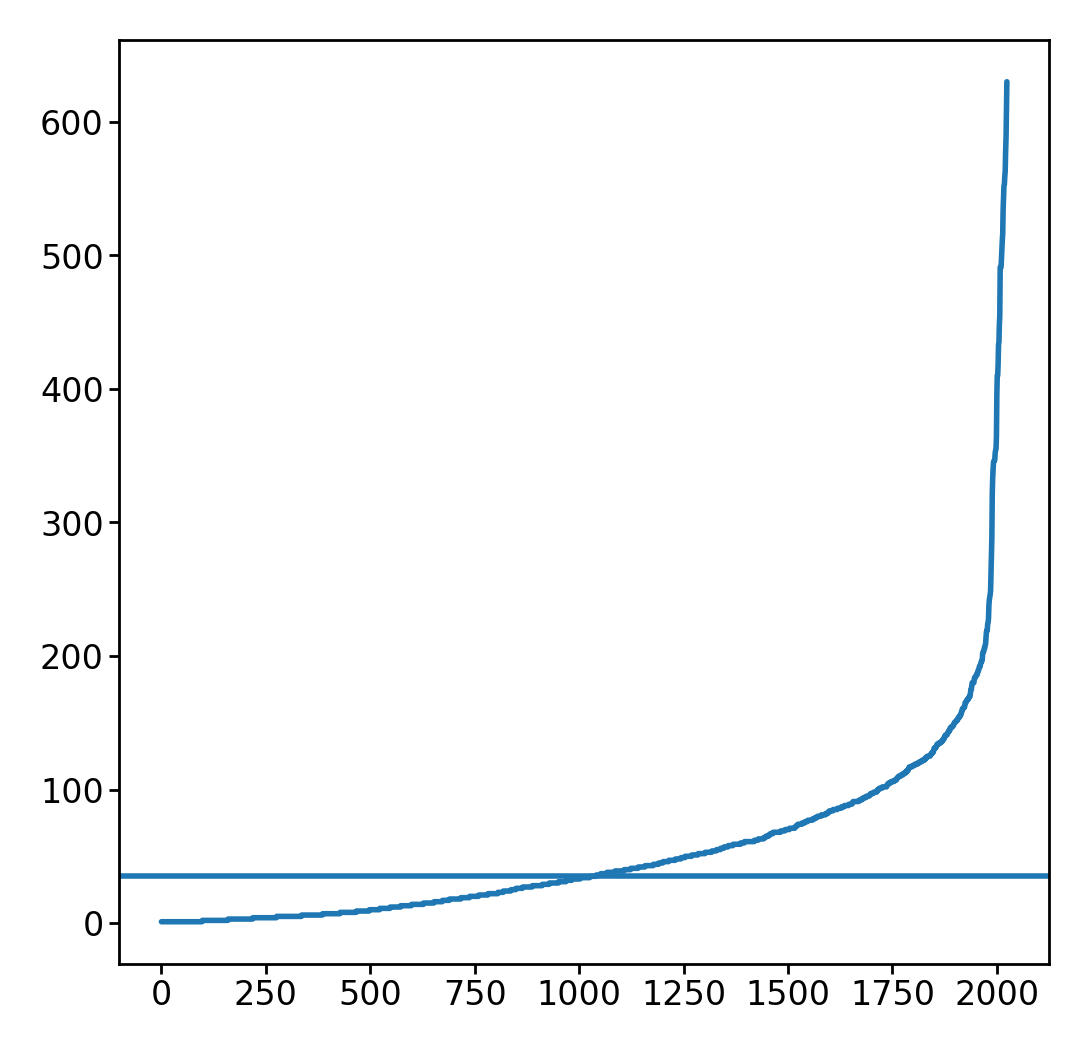

In [19]:
plt.plot(syll_counts.loc['12w'].sort_values().to_numpy())
plt.axhline(35)

In [20]:
da_usage = pd.DataFrame(syll_counts).join(out)
da_usage = da_usage.query('count > 45')
da_usage['Peak DA'] = da_usage.groupby('uuid')['Peak DA'].transform(zscore)
da_usage['count'] = da_usage.groupby('uuid')['count'].transform(zscore)

In [22]:
da_usage.groupby('age').corr(method='spearman')

count   Peak DA
age                            
12w count    1.000000  0.181221
    Peak DA  0.181221  1.000000
52w count    1.000000  0.177718
    Peak DA  0.177718  1.000000
98w count    1.000000  0.101669
    Peak DA  0.101669  1.000000

In [23]:
tmp = da_usage.groupby(['age', 'subject_name', 'syllables']).mean()

In [24]:
# tmp['Peak DA'] = tmp.groupby('subject_name')['Peak DA'].transform(zscore)

In [25]:
tmp.groupby('age').corr(method='spearman')

count   Peak DA
age                            
12w count    1.000000  0.272642
    Peak DA  0.272642  1.000000
52w count    1.000000  0.103295
    Peak DA  0.103295  1.000000
98w count    1.000000  0.085706
    Peak DA  0.085706  1.000000

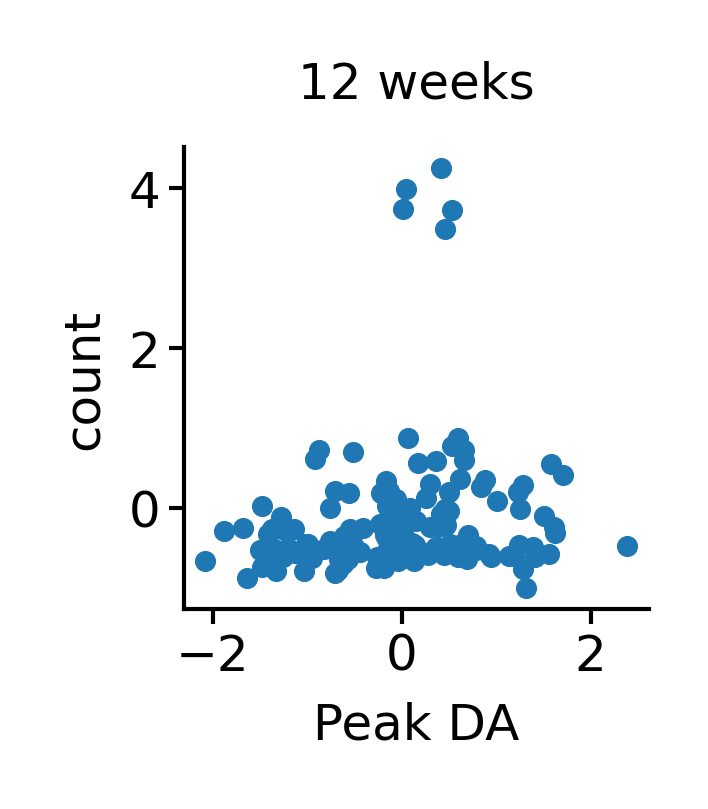

In [30]:
fig = figure(1, 1)
ax = tmp.loc['12w'].plot(kind='scatter', x='Peak DA', y='count', s=3, ax=fig.gca())
ax.set(title='12 weeks')
sns.despine()

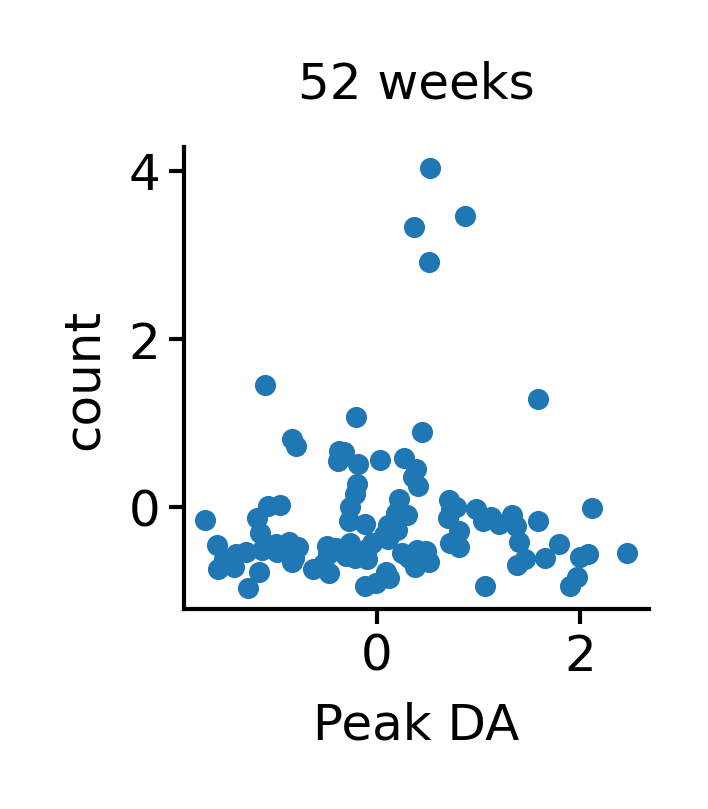

In [31]:
fig = figure(1, 1)
ax = tmp.loc['52w'].plot(kind='scatter', x='Peak DA', y='count', s=3, ax=fig.gca())
ax.set(title='52 weeks')
sns.despine()

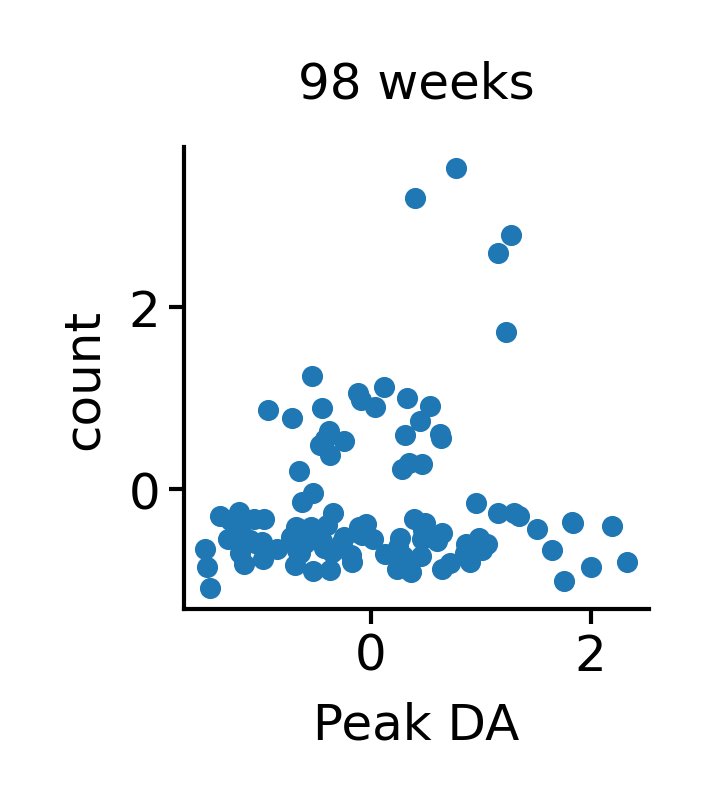

In [32]:
fig = figure(1, 1)
ax = tmp.loc['98w'].plot(kind='scatter', x='Peak DA', y='count', s=3, ax=fig.gca())
ax.set(title='98 weeks')
sns.despine()

[Text(64.68651041666664, 0.5, 'Syllable counts'),
 Text(0.5, 36.0, 'Peak DA (z)')]

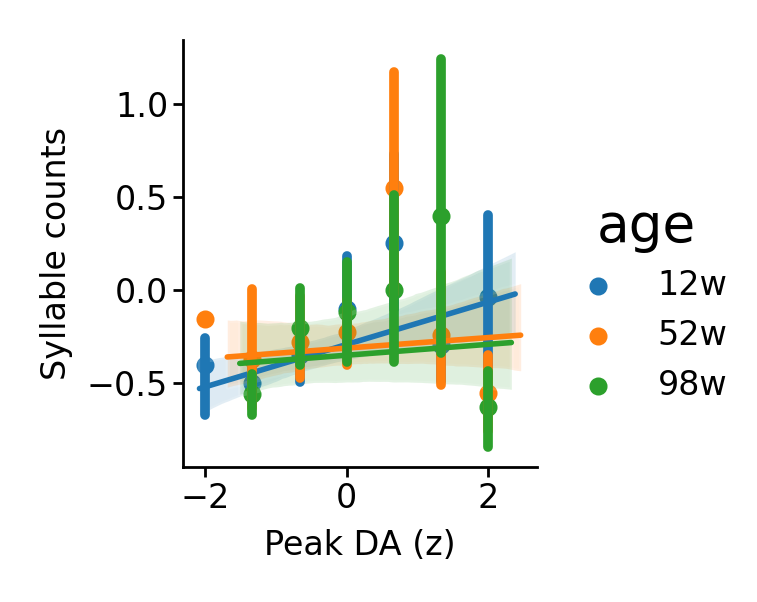

In [35]:
g = sns.lmplot(
    data=tmp.reset_index(),
    x="Peak DA",
    y="count",
    hue="age",
    x_bins=np.linspace(-2, 2, 7),
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
    robust=True
)
g.ax.set(ylabel="Syllable counts", xlabel="Peak DA (z)")
# saver(g.fig, "dlight-vs-counts-vs-age");

In [30]:
filt_df.head()

,pmt00_ref00 (dLight),pmt00_ref01 (UV),timestamp,raw_timestamp,fs,ir_indices,subject_name,session_name,start_time,syllables,...,dlight_reref,uv_reference_fit,dlight_reref_zscore,dlight_reref_zscore_filter,onsets,relabeled_syllables,session_motion_corr,snr,rolling_motion_corr,age
54000,0.026147,0.011056,0.000000,2.839133e+09,29.962547,0.0,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.016558,0.001491,1.150043,1.764906,True,46,0.109966,4.684033,NaN,98w
54001,0.026044,0.011174,0.033375,2.839133e+09,29.962547,NaN,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.009021,0.004891,0.493352,1.213703,True,46,0.109966,4.684033,NaN,98w
54002,0.026023,0.011264,0.066750,2.839133e+09,29.962547,1.0,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.005126,0.007885,0.153601,0.704451,True,46,0.109966,4.684033,NaN,98w
54003,0.026032,0.011270,0.100062,2.839134e+09,29.962547,NaN,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,0.003823,0.010259,0.038547,0.255265,True,46,0.109966,4.684033,NaN,98w
54004,0.025958,0.011242,0.133375,2.839134e+09,29.962547,2.0,98w-3,dlight-aging,2023-08-07 12:55:05.062630,-5,...,-0.000541,0.012030,-0.372114,-0.133419,True,46,0.109966,4.684033,NaN,98w


In [36]:
def compute_tm(df, max_syll=100):
    freq_dict = frequencies(sliding_window(2, df['relabeled_syllables'].to_numpy()))
    arr = np.zeros((max_syll, ) * 2)
    for k, v in freq_dict.items():
        arr[k] = v
    return arr

In [37]:
def compute_entropy(tm, count_thresh=30):
    keep = np.where(tm.sum(1) >= count_thresh)[0]
    ent = entropy(tm[keep] + 1, axis=1)
    ser = pd.Series(dict(zip(keep, ent)), name='entropy')
    ser.index.name = 'syllables'
    return ser

In [38]:
fun = compose(
    partial(compute_entropy, count_thresh=50), partial(compute_tm, max_syll=61)
)
ent_out = filt_df.query("onsets").groupby(["age", "subject_name", "uuid"]).apply(fun)

/tmp/ipykernel_4442/2560500366.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ent_out = filt_df.query("onsets").groupby(["age", "subject_name", "uuid"]).apply(fun)


In [39]:
da_ent = pd.DataFrame(ent_out).join(out)
da_ent['Peak DA'] = da_ent.groupby('uuid')['Peak DA'].transform(zscore)
da_ent['entropy'] = da_ent.groupby('uuid')['entropy'].transform(zscore)

In [40]:
da_ent.groupby('age').corr(method='spearman')

entropy   Peak DA
age                            
12w entropy  1.000000  0.100787
    Peak DA  0.100787  1.000000
52w entropy  1.000000  0.310704
    Peak DA  0.310704  1.000000
98w entropy  1.000000 -0.001434
    Peak DA -0.001434  1.000000

In [41]:
da_ent = da_ent.groupby(['age', 'subject_name', 'syllables']).mean()

In [42]:
da_ent.groupby('age').corr(method='spearman')

entropy   Peak DA
age                            
12w entropy  1.000000  0.063279
    Peak DA  0.063279  1.000000
52w entropy  1.000000  0.447330
    Peak DA  0.447330  1.000000
98w entropy  1.000000  0.029930
    Peak DA  0.029930  1.000000

[Text(59.74510416666665, 0.5, 'Entropy (nats)'),
 Text(0.5, 36.0, 'Peak DA (z)')]

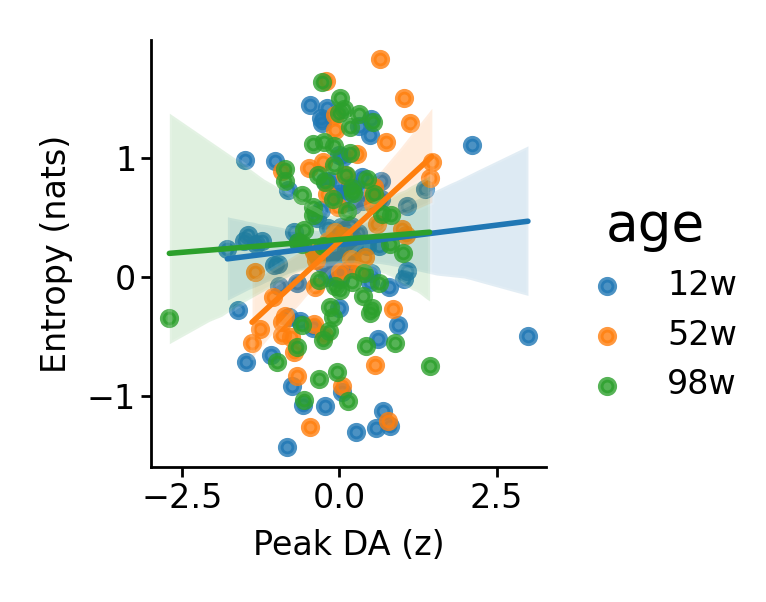

In [43]:
g = sns.lmplot(
    data=da_ent.reset_index(),
    x="Peak DA",
    y="entropy",
    hue="age",
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
    robust=True,
    n_boot=400,
)
g.ax.set(ylabel="Entropy (nats)", xlabel="Peak DA (z)")

[Text(64.68651041666664, 0.5, 'Entropy (nats)'),
 Text(0.5, 36.0, 'Peak DA (z)')]

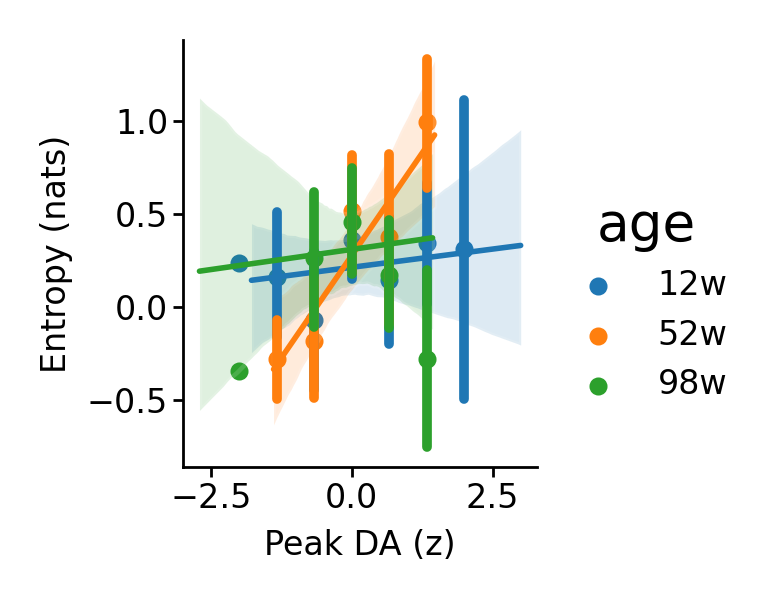

In [74]:
g = sns.lmplot(
    data=da_ent.reset_index(),
    x="Peak DA",
    y="entropy",
    hue="age",
    x_bins=np.linspace(-2, 2, 7),
    height=1.5,
    aspect=1,
    scatter_kws=dict(s=6),
    line_kws=dict(lw=1),
)
g.ax.set(ylabel="Entropy (nats)", xlabel="Peak DA (z)")
# saver(g.fig, "dlight-vs-entropy-vs-age");